# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


## Question 1

(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
#def P1(num_examples=5):
### STUDENT START ###
for i in range(0,5):
    print 'LABEL %d' %train_labels[i]
    print train_data[i]
### STUDENT END ###
#P1()

LABEL 1
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
LABEL 3


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
LABEL 2

 >In article <1993Apr19.020359.26996

## Question 2

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [4]:
# a
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(train_data)
average_number_features = vectors.nnz/vectors.shape[0]
fraction_nnz_of_matrix = float(vectors.nnz)/(vectors.shape[0] * vectors.shape[1])

print 'Size of vocabulary is %d features' %vectors.shape[1]
print 'Average number of non-zero features is %d per example' %average_number_features
print 'fraction of entries being non-zero %.5f' % fraction_nnz_of_matrix

Size of vocabulary is 26879 features
Average number of non-zero features is 96 per example
fraction of entries being non-zero 0.00360


In [5]:
# b What are the 0th and last feature strings (in alphabetical order)?
print 'First feature string: %s' %vectorizer.get_feature_names()[0]
print 'Last feature string: %s' %vectorizer.get_feature_names()[-1]

First feature string: 00
Last feature string: zyxel


In [6]:
# c Specify your own vocabulary with 4 words
short_vocabulary = ["atheism", "graphics", "space", "religion"]
vectorizer = CountVectorizer(vocabulary = short_vocabulary)
vectors = vectorizer.fit_transform(train_data)
print vectors.shape
average_number_features = float(vectors.nnz)/vectors.shape[0]
print 'Average number of non-zero features is %.2f per example' %average_number_features

(2034, 4)
Average number of non-zero features is 0.27 per example


In [7]:
# d extract bigram and trigram character features
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
vectors = bigram_vectorizer.fit_transform(train_data)
print "Numbers of features for a bigram: %d" %vectors.shape[1]

trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
vectors = trigram_vectorizer.fit_transform(train_data)
print "Numbers of features for a trigram: %d" %vectors.shape[1]

analyze = bigram_vectorizer.build_analyzer()
bigram_example = analyze(train_data[1])
print 'Example of bigrams:' + str((bigram_example[-5:]))

Numbers of features for a bigram: 221770
Numbers of features for a trigram: 537462
Example of bigrams:[u'demonstrating such', u'such evil', u'evil corruption', u'corruption for', u'for centuries']


In [8]:
# e prune words that appear in fewer than 10 documents
vectorizer = CountVectorizer(min_df = 10)
vectors = vectorizer.fit_transform(train_data)
vectors.shape
print 'Size of vocabulary is %d features' %vectors.shape[1]

Size of vocabulary is 3064 features


In [9]:
#f what fraction of the words in the dev data are missing from the vocabulary
vectorizer_train = CountVectorizer()
vectors_train = vectorizer_train.fit_transform(train_data)
voc_train = vectorizer_train.get_feature_names()


vectorizer_dev = CountVectorizer()
vectors_dev = vectorizer_dev.fit_transform(dev_data)
voc_dev = vectorizer_dev.get_feature_names()

common_vocabulary = set(voc_dev).intersection(voc_train)
fraction_missing = float(vectors_dev.shape[1] - len(common_vocabulary))/vectors_dev.shape[1]
print 'Fraction of vocabulary missing %.3f' %fraction_missing

Fraction of vocabulary missing 0.248


## Question 3

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [10]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(train_data)
vectors_test = vectorizer.transform(dev_data)

# Multinomial Naive Bayes
alphas = {'alpha':[0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
multi = MultinomialNB()
clf = GridSearchCV(multi, alphas)
clf.fit(vectors, train_labels)
pred = clf.predict(vectors_test)
print 'F1 score for Multinomial Naive Bayes: %.3f' %(metrics.f1_score(dev_labels, 
                                                                      pred, average='macro'))
# Nearest neighbors
ks = {'n_neighbors': range(1, 11)}
kn = KNeighborsClassifier()
clf = GridSearchCV(kn, ks)
clf.fit(vectors, train_labels)
pred = clf.predict(vectors_test)
print 'F1 score for Nearest Neighbors: %.3f' %(metrics.f1_score(dev_labels, 
                                                                pred, average='macro'))
# Logistic regression
cs = {'C':[0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
lo = LogisticRegression(penalty='l2')
clf = GridSearchCV(lo, cs)
clf.fit(vectors, train_labels)
pred = clf.predict(vectors_test)
print 'F1 score for Logistic Regression: %.3f' %(metrics.f1_score(dev_labels, 
                                                                  pred, average='macro'))

/Users/ozimmer/anaconda/lib/python2.7/site-packages/sklearn/naive_bayes.py:664: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)


F1 score for Multinomial Naive Bayes: 0.755
F1 score for Nearest Neighbors: 0.413
F1 score for Logistic Regression: 0.692


In [11]:
# Logistic regression - relationship between the sum of square and the value of C
cs = {'C':[0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

def sum_of_squares(n):
    return round(sum([i**2 for i in n]), 2)

for c in cs['C']:
    lo = LogisticRegression(penalty='l2', C=c)
    lo.fit(vectors, train_labels)
    print 'C parameter of: %.3f' %c
    print 'Sum of squares for each class: ' + str([sum_of_squares(lo.coef_[i,]) 
                                                 for i in range(0, lo.coef_.shape[0])])

C parameter of: 0.000
Sum of squares for each class: [0.01, 0.01, 0.01, 0.01]
C parameter of: 0.001
Sum of squares for each class: [0.17, 0.2, 0.18, 0.19]
C parameter of: 0.010
Sum of squares for each class: [2.54, 2.94, 2.86, 2.25]
C parameter of: 0.100
Sum of squares for each class: [27.13, 24.65, 27.46, 23.03]
C parameter of: 0.500
Sum of squares for each class: [102.62, 83.1, 98.98, 89.01]
C parameter of: 1.000
Sum of squares for each class: [166.99, 130.9, 157.98, 145.77]
C parameter of: 2.000
Sum of squares for each class: [257.56, 197.84, 239.82, 226.53]
C parameter of: 10.000
Sum of squares for each class: [586.19, 447.8, 539.97, 531.2]


ANSWER:

### question a
There are too many features (in this model 26879 words) for nearest neighbors. Whereas Naive Bayes take into account a broader set of features, the current model for knn takes into account 5 neighbors only, thus the poor performance.

### question b
Naive Bayes has the independence assumption, if 2 features are heavily weighted towards a label, their weight will add up. Logistic regression looks at linear relation between the labels and the features - the 2 same features with high contribution will have have their weight lower down if being strongly correlated to each other (collinearity issue). 

### question c

C is the inverse regularization strength (in this case L2), the stronger the regularisation the closer the weights will be to 0 -> thus smaller sum of squares with smaller C

## Question 4

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [12]:
# Function to map the top 5 coeff per classes
def logistic_reg_top_5(ngram, train_data, dev_data, train_labels):
    vectorizer = CountVectorizer(ngram_range=(1, ngram))
    vectors = vectorizer.fit_transform(train_data)
    vectors_test = vectorizer.transform(dev_data)

    lo = LogisticRegression(penalty='l2', C = 1.0)
    lo.fit(vectors, train_labels)
    pred = lo.predict(vectors_test)

    np_coeff = np.zeros(20)
    table_coeff = np.zeros((20, 4))

    for i in range(0,4):
        np_coeff[0 + 5*i:5 + 5*i] = lo.coef_[i,].argsort()[-5:]
    list_coeff = map(int, np_coeff.tolist())
    print[vectorizer.get_feature_names()[j] for j in list_coeff]

    for i in range(0,4):
        table_coeff[0:20, i] = lo.coef_[i,][list_coeff]
    print(table_coeff)

# Creating the top 5 coeff table for unigram & bigram
logistic_reg_top_5(1, train_data, dev_data, train_labels)
logistic_reg_top_5(2, train_data, dev_data, train_labels)

[u'atheism', u'religion', u'bobby', u'atheists', u'deletion', u'computer', u'3d', u'file', u'image', u'graphics', u'spacecraft', u'launch', u'nasa', u'orbit', u'space', u'order', u'fbi', u'blood', u'christian', u'christians']
[[ 0.93973023 -0.4103703  -0.44948498 -0.43475441]
 [ 0.95393712 -0.6169444  -0.79236897 -0.06440608]
 [ 0.98986627 -0.2208606  -0.3406296  -0.46337993]
 [ 1.03072037 -0.09716371 -0.32093796 -0.83516006]
 [ 1.12523474 -0.3980162  -0.42048434 -0.39552433]
 [ 0.14386287  0.97770855 -0.68186034 -0.48729047]
 [-0.35894574  1.12498035 -0.70207303 -0.37830812]
 [-0.33471196  1.266456   -0.80664706 -0.62679561]
 [-0.58283779  1.34628462 -0.82622764 -0.46842352]
 [-0.75835629  1.93658844 -1.33605119 -0.7627053 ]
 [-0.35549769 -0.39339767  0.9199665  -0.38058228]
 [-0.47069137 -0.46529323  0.9364947  -0.33233669]
 [-0.57248653 -0.47929421  1.01140019 -0.46764634]
 [-0.41389561 -0.671399    1.22479915 -0.6292181 ]
 [-1.26033166 -1.31591209  2.16236714 -1.17080998]
 [-0.7935

ANSWER: Bigram logistic regression has an impact on the weight of the features, the weights are lower as probably there are more features taken into account into the model. Seems also surprising to see features such "hi" or "see" that seem very generic to be know in our top 20 table.

## Question 5

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [13]:
# Non-preprocessed data
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(train_data)
vectors_test = vectorizer.transform(dev_data)
lo = LogisticRegression(penalty='l2')
lo.fit(vectors, train_labels)
pred = lo.predict(vectors_test)
print 'F1 score for Logistic Regression: %.3f' %(metrics.f1_score(dev_labels, 
                                                                  pred, average='macro'))

# Preprocessed data, replace numbers by a single token & remove non-letters
# lowercase=True seems to be already the default option for countvectorizer()
def better_preprocessor(s):
    s = s.lower()
    s = re.sub(r'_', "", s)
    match = re.match(r'[0-9]', s)
    if match:
        s = "number"
    else:
        s
    return s
vectorizer = CountVectorizer(preprocessor = better_preprocessor)
vectors = vectorizer.fit_transform(train_data)
vectors_test = vectorizer.transform(dev_data)
lo = LogisticRegression(penalty='l2')
lo.fit(vectors, train_labels)
pred = lo.predict(vectors_test)
print 'F1 score for Logistic Regression preprocessed: %.3f' %(metrics.f1_score(dev_labels, 
                                                                  pred, average='macro'))

F1 score for Logistic Regression: 0.679
F1 score for Logistic Regression preprocessed: 0.689


## Question 6

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

In [14]:
# Keep this random seed here to make comparison easier.
np.random.seed(0)

vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(train_data)
vectors_test = vectorizer.transform(dev_data)

lo = LogisticRegression(penalty='l2', C=1.0)
lo.fit(vectors, train_labels)
print 'Logistic regression with L2 regularization: %d non-zero weights' %np.count_nonzero(lo.coef_)

lo = LogisticRegression(penalty='l1', C=1.0)
lo.fit(vectors, train_labels)
pred = lo.predict(vectors_test)
print 'Logistic regression with L1 regularization: %d non-zero weights' %np.count_nonzero(lo.coef_)

# Save non-zero features under L1 regularization to reduce vocabulary
def get_new_vocabulary(lo, vectorizer):
    non_zero_coef = np.nonzero(lo.coef_)
    non_zero_coef_list = non_zero_coef[1]
    new_vocabulary = [vectorizer.get_feature_names()[i] for i in non_zero_coef_list]
    new_vocabulary = list(set(new_vocabulary))# Remove duplicates in new_vocabulary
    return new_vocabulary
new_vocabulary = get_new_vocabulary(lo, vectorizer)

Logistic regression with L2 regularization: 107516 non-zero weights
Logistic regression with L1 regularization: 1636 non-zero weights


Re-running the model with 977 features


/Users/ozimmer/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


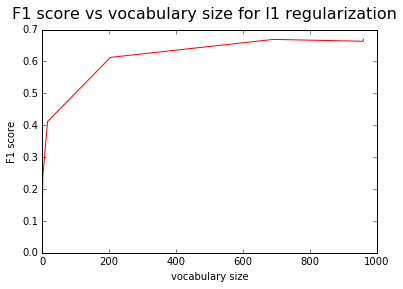

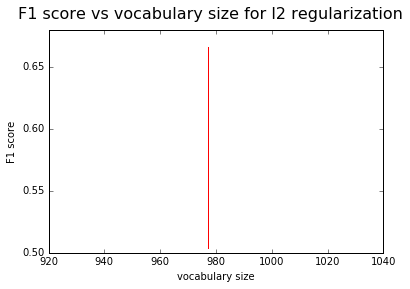

In [15]:
print 'Re-running the model with %d features' %len(new_vocabulary)

vectorizer = CountVectorizer(vocabulary = new_vocabulary)
vectors = vectorizer.fit_transform(train_data)
cs = {'C':[0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0]}

# L2 regularization makes the weight of the features really small but doesn't prune out features
# While L1 regularization prunes out features -> thus the vocabulary list varies
# Plot logistic regression with different C and L1/L2
def plot_logistic(L, cs, vectors, train_labels, dev_data, vectors_test, vectorizer):
    voc_size = []
    f1_score_list = []
    for c in cs['C']:
        lo = LogisticRegression(penalty=L, C=c)
        lo.fit(vectors, train_labels)
        vectors_test = vectorizer.transform(dev_data)
        pred = lo.predict(vectors_test)
        voc_size.append(len(get_new_vocabulary(lo, vectorizer)))
        f1_score = metrics.f1_score(dev_labels, pred, average='macro')
        f1_score_list.append(f1_score)
        #print 'C: %.3f F1 score: %.4f' %(c, metrics.f1_score(dev_labels, pred, average='macro'))

    fig = plt.figure()
    plt.plot(voc_size, f1_score_list, color='red')
    plot_title = 'F1 score vs vocabulary size for ' + L + ' regularization'
    fig.suptitle(plot_title, fontsize=16)
    plt.xlabel('vocabulary size')
    plt.ylabel('F1 score') 
    plt.show()

plot_logistic('l1', cs, vectors, train_labels, dev_data, vectors_test, vectorizer)
plot_logistic('l2', cs, vectors, train_labels, dev_data, vectors_test, vectorizer)

## Question 7

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [16]:
#train on trigram
trigram_vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=1)
vectors = trigram_vectorizer.fit_transform(train_data)
vectors_test = trigram_vectorizer.transform(dev_data)
lo = LogisticRegression(penalty='l2', C=100.0)
lo.fit(vectors, train_labels)

# Get R = maximum predicted probability / probability of the dev label
prob_dev_label = np.zeros(dev_labels.shape[0])
max_predic_proba = np.zeros(dev_labels.shape[0])
R = max_predic_proba = np.zeros(dev_labels.shape[0])

for i in range(0, lo.predict_proba(vectors_test).shape[0]):
    j = dev_labels[i]
    prob_dev_label[i] = lo.predict_proba(vectors_test)[i, j]
    index = lo.predict_proba(vectors_test)[i].argmax()
    max_predic_proba[i] = lo.predict_proba(vectors_test)[i, index]
    R[i] = max_predic_proba[i] / prob_dev_label[i]
top_3_R = R.argsort()[-3:]
print 'The 3 documents where R is the largest are '
print R[top_3_R]

for i in top_3_R:
    print 'document id: %d' %i
    print dev_data[i]

The 3 documents where R is the largest are 
[ 162.91634371  285.59319955  669.68455264]
document id: 471
Why is the NT tossed out as info on Jesus.  I realize it is normally tossed
out because it contains miracles, but what are the other reasons?

MAC
--
****************************************************************
                                                    Michael A. Cobb
 "...and I won't raise taxes on the middle     University of Illinois
    class to pay for my programs."                 Champaign-Urbana
          -Bill Clinton 3rd Debate             cobb@alexia.lis.uiuc.edu
document id: 655
In <1ren9a$94q@morrow.stanford.edu> salem@pangea.Stanford.EDU (Bruce Salem) 



This brings up another something I have never understood.  I asked this once
before and got a few interesting responses, but somehow didn't seem satisfied.
Why would the NT NOT be considered a good source.  This might be a 
literary/historical question, but when I studied history I always looked for 
fir

ANSWER: CountVectorizer followed by TfidfTransformer. TFidf re-weights words such as  “the”, “a”, “is” in English that are being present is every document, thus carry low information. The issue we have here is around calibration - as the model tends to be overconfident on certain labels. We could here reduce C (at 100) which would increase the regularization factor to compensentate this issue.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.